<a href="https://colab.research.google.com/github/OleksiiLatypov/Practical_Deep_Learning_with_PyTorch/blob/main/week3/pneumonia_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'rsna-pneumonia-detection-challenge:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F10338%2F862042%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240508%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240508T205241Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D3cbc1220b5cd94b9e946687d1c9fb2e85fab81f0717e658c5aff5afe7340bc32b36aea6d8f3e6afa49431d27924d6b84319dc7dbe2a487eaf9ab8ebd37a59e676bfb482c36369063a03ac7292493f2c1154edcd16d8aedd7825635e5ecb12101549e47f235ff2d359f29dd0b4dfac5cf25005f8b598d38f0a6444d505ab4e0ddde61df1f25ac413bfb50d969ba1ccfe7ce51143bcfcfcafb0328a8538a5b34b926ce7731ba7566d6206b542c4d249342272a46201ccd3c5629b2a61edfabb8f63acd0a1bdd63f93f2f85fd854637a1566c39b8cb5763b544ffa6d659a204eac48a609484f894ff5826b75504f01f4f4ac5cd0253e878d9b14498ae220c92a5ab'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
from sklearn.model_selection import train_test_split
from pydicom import dcmread
import matplotlib.pyplot as plt
import os


from PIL import Image
import torch
import torch.nn as nn
import torchvision
from torchvision.transforms import transforms
from torch.utils import data

In [ ]:
label_data = pd.read_csv('/kaggle/input/rsna-pneumonia-detection-challenge/stage_2_train_labels.csv')
columns = ['patientId', 'Target']
label_data = label_data[columns]
label_data.head()

,patientId,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,0
4,00436515-870c-4b36-a041-de91049b9ab4,1


In [ ]:
train_labels, val_labels = train_test_split(label_data, test_size=0.1)
print(train_labels.shape)
print(val_labels.shape)

(27204, 2)
(3023, 2)


# **Prepare images paths**

In [ ]:
train_images = '/kaggle/input/rsna-pneumonia-detection-challenge/stage_2_train_images'
test_images = '/kaggle/input/rsna-pneumonia-detection-challenge/stage_2_test_images'

train_paths = [os.path.join(train_images, i[0]) for i in train_labels.values]
test_paths = [os.path.join(test_images, i[0]) for i in val_labels.values]
print(train_paths.__len__())
print(test_paths.__len__())

27204
3023


In [ ]:
train_paths[:10]

['/kaggle/input/rsna-pneumonia-detection-challenge/stage_2_train_images/1d9dde4e-97cc-4163-a3d5-8b845ad60ded',
 '/kaggle/input/rsna-pneumonia-detection-challenge/stage_2_train_images/d967c678-30f0-48b4-9563-167e746e972d',
 '/kaggle/input/rsna-pneumonia-detection-challenge/stage_2_train_images/2392ac11-428d-4739-9ac7-d170aedd262d',
 '/kaggle/input/rsna-pneumonia-detection-challenge/stage_2_train_images/b9533502-8a65-4951-a4e4-2448a56057c9',
 '/kaggle/input/rsna-pneumonia-detection-challenge/stage_2_train_images/47fbefac-6c3a-4433-83d1-90585ed76bb1',
 '/kaggle/input/rsna-pneumonia-detection-challenge/stage_2_train_images/a4dbfeca-474b-4641-ab2f-7b376dea9fd8',
 '/kaggle/input/rsna-pneumonia-detection-challenge/stage_2_train_images/eb3aff4d-df68-4d3e-a858-e8a28df962ca',
 '/kaggle/input/rsna-pneumonia-detection-challenge/stage_2_train_images/4f632aa2-9af4-4c37-9e42-cb9970e1bbbf',
 '/kaggle/input/rsna-pneumonia-detection-challenge/stage_2_train_images/62946b4b-efbd-473b-a878-833b04ccc016',
 

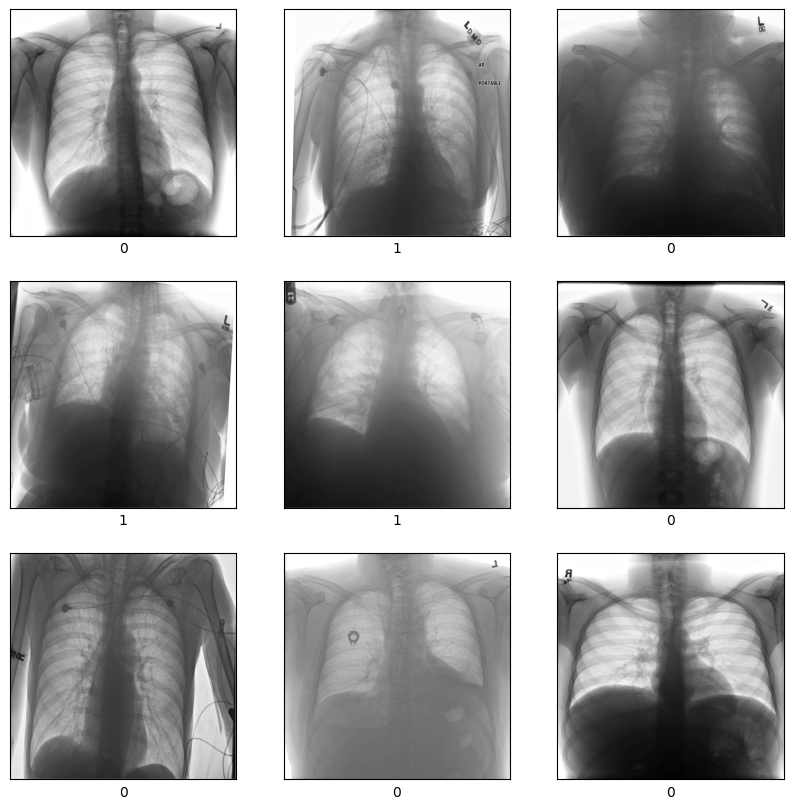

In [ ]:
def imshow(num_to_show=9):

    plt.figure(figsize=(10,10))

    for i in range(num_to_show):
        plt.subplot(3, 3, i+1)
        plt.grid(False)
        plt.xticks([])
        plt.yticks([])

        img_dcm = dcmread(f'{train_paths[i+20]}.dcm')
        img_np = img_dcm.pixel_array
        plt.imshow(img_np, cmap=plt.cm.binary)
        plt.xlabel(train_labels.values[i+20][1])

imshow()

In [ ]:
label_data['Target'].value_counts()

Target
0    20672
1     9555
Name: count, dtype: int64

# **Composing transformations**

In [ ]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.Resize(224),
    transforms.ToTensor()
])

**Write a custom dataset**

In [ ]:
class Dataset(data.Dataset):
    def __init__(self, paths, labels, transform=None):
        self.paths = paths
        self.labels = labels
        self.transform = transform

    def __getitem__(self, index):
        image = dcmread(f'{self.paths[index]}.dcm')
        image = image.pixel_array
        image = image / 255.0
        image = (image * 255.0).clip(0, 255).astype(np.uint8)
        image = Image.fromarray(image).convert('RGB')
        label = self.labels[index][1]

        if self.transform is not None:
            image = self.transform(image)
        return image, label

    def __len__(self):
        return len(self.paths)



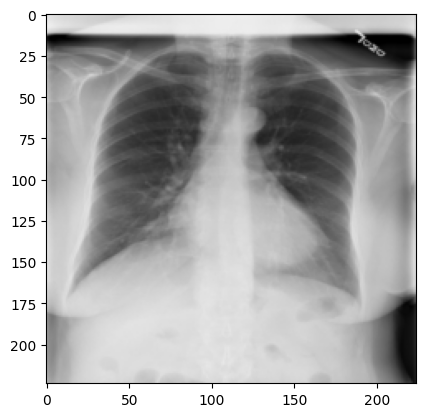

In [ ]:
train_dataset = Dataset(train_paths, train_labels.values, transform=transform)
train_dataset[1]
img = np.transpose(train_dataset[1][0], (1, 2, 0))
plt.imshow(img)